In [4]:
import os
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import pandas as pd
import csv
from glob import glob
from sklearn.metrics import f1_score

In [5]:
id2label = {
    0: 'Idle',
    1: 'Toric Marking',
    2: 'Implant Ejection',
    3: 'Incision',
    4: 'Viscodilatation',
    5: 'Capsulorhexis',
    6: 'Hydrodissetion',
    7: 'Nucleus Breaking',
    8: 'Phacoemulsification',
    9: 'Vitrectomy',
    10: 'Irrigation/Aspiration',
    11: 'Preparing Implant',
    12: 'Manual Aspiration',
    13: 'Implantation',
    14: 'Positioning',
    15: 'OVD Aspiration',
    16: 'Suturing',
    17: 'Sealing Control',
    18: 'Wound Hydratation',
}

label2id = {v: k for k, v in id2label.items()}

## 推論結果の可視化

In [36]:
predict_csv = '/data1/github/MICCAI2020/cataractsWorkflow/result/cnn_only/tf-xception-skipframe=1/predict/train/23/train23.csv'
target_csv = '/data1/github/MICCAI2020/cataractsWorkflow/data/train/23/train23.csv'

In [37]:
df_pr = pd.read_csv(predict_csv)
df_gt = pd.read_csv(target_csv)

In [49]:
df_pr

,Frame,Steps
0,1,11
1,2,11
2,3,11
3,4,11
4,5,11
...,...,...
11177,11178,0
11178,11179,0
11179,11180,0
11180,11181,0


In [297]:
map_ = np.eye(19)[df_gt['Steps']]

In [301]:
map_[::1].shape

(11182, 19)

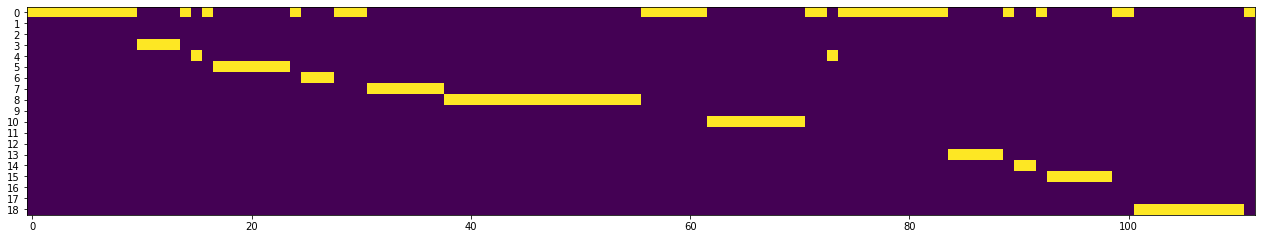

In [136]:
plt.figure(figsize=(22, 14))
plt.yticks(np.arange(0, 19, 1))
plt.imshow(np.eye(19)[df_gt['Steps']].T[:, ::100])

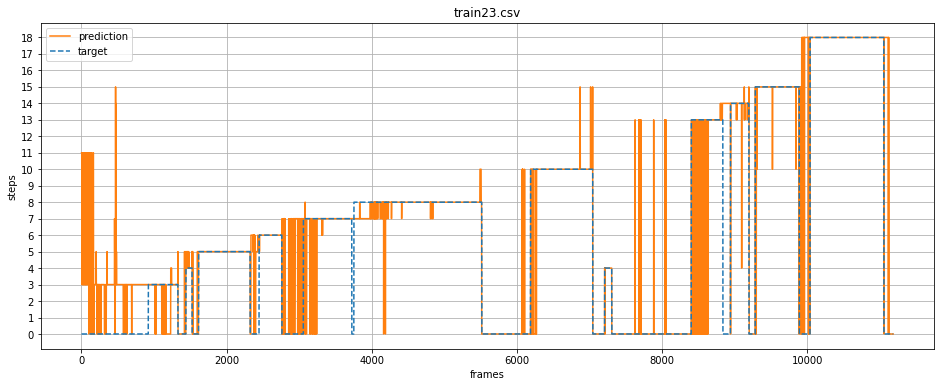

In [99]:
# build instance
plt.figure(figsize=(16, 6))
plt.gca().get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))  # 縦軸目盛を整数に

# plot
plt.plot(df_pr['Frame'], df_pr['Steps'], label='prediction', color='tab:orange')
plt.plot(df_gt['Frame'], df_gt['Steps'], label='target', color='tab:blue', linestyle='dashed')

plt.title(os.path.basename(target_csv))
plt.xlabel('frames')
plt.ylabel('steps')
plt.yticks(np.arange(0, 19, 1))  # 縦軸目盛を明示的につける
plt.grid()
plt.legend()

plt.show()

In [329]:
import os
import numpy as np
import pandas as pd
import gym


class ProcedureMaze(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, csv_file, skip_frame=1):
        """`action_space`, `observation_space`, `reward_range` are necessary
        """
        super().__init__()
        # 予測結果から迷路を生成
        self.maze = self._generate_maze(csv_file, skip_frame)

        self.action_space = gym.spaces.Discrete(19)  # classes: 18 + 1
        self.observation_space = gym.spaces.Box(
            low=0,
            high=self.maze.shape[0],
            shape=(2, )
        )  # [frame, task]
        self.reward_range = [-1., 1000.]
        # 環境を初期化
        self.reset()

    def reset(self):
        """necessary method
        """
        self.steps = 0
        self.pos = [1, 0]  # はじめはframe_id=1,task=0から始まる
        self.goal = [self.maze.shape[0], np.argmax(self.maze[-1])]  # ゴールはフレームの最後とそのtask_id
        self.done = False
        return self.pos

    def step(self, action):
        """necessary method
        actionを行った処理（1回ごと）
        return: observation(state), reward, done(episode終了判定), info(追加の情報の辞書)
        """
        # x座標は常に進める
        # actionがそのままy座標となる
        next_pos = [self.pos[0] + 1, action]

        if self._is_movable(next_pos):
            self.pos = next_pos
        else:
            self.done = True

        # observation = self._observe()
        observation = self.pos  # 移動先の座標を観測とする
        reward = self._get_reward(self.pos)
#         self.done = self._is_done()
        return observation, reward, self.done, {}

    def render(self, mode='human', close=False):
        """necessary method
        """
        if mode == 'rgb_array':
            output = self.maze.copy()
            output[self.pos[0], self.pos[1]] = 2  # 現在地を2とする
            return output
        
        elif mode == 'human':
            target = self.maze.copy()
            target = np.argmax(target, axis=-1)  # to class_id from onehot
            # [class_id(pred), class_id(target)]
            output = [self.pos[1], target[self.pos[0]]]
            return output

    def _get_reward(self, pos):
        """報酬を計算
        """
        if self.goal == pos:
            # ゴールにたどり着くと高い報酬を与える
            # TODO: ゴールの報酬をいくつに設定するか？
            return 1000
        elif self.pos[1] == np.argmax(self.maze[self.pos[0]]):
            # 予測のtaskと同じだと報酬を与える
            return 1
        else:
            # 予測のtaskと異なるとペナルティを与える
            return -1

    def _is_done(self):
        """終了判定
        """
        if self.pos[0] == self.maze.shape[0]:
            return True
        else:
            return False

    def _observe(self):
        """手術画像を入力とするときに使用
        """
        pass

    def _generate_maze(self, csv_file, skip_frame=1):
        df = pd.read_csv(csv_file)
        onehot = np.eye(19)[df["Steps"]]  # 19 classes
        return onehot[::skip_frame]

    def _is_movable(self, pos):
        # x軸方向に進めなくなったらFalseを返す
        return self.goal[0] != pos[0]


In [333]:
env = ProcedureMaze(target_csv, skip_frame=600)
env.action_space.n

19

In [338]:
frames = []
for episode in range(1):
    state = env.reset()
    frames.append(env.render(mode='human'))
    print(state)
    done = False
    steps = 0
    while not done:
        action = np.random.randint(env.action_space.n)
        state, reward, done, _ = env.step(action)
        frames.append(env.render(mode='human'))
        print(state, reward)
        steps += 1
        
#         if steps > 100:
#             break
env.close()

[1, 0]
[2, 17] -1
[3, 0] -1
[4, 4] -1
[5, 18] -1
[6, 1] -1
[7, 3] -1
[8, 3] -1
[9, 9] -1
[10, 15] -1
[11, 6] -1
[12, 1] -1
[13, 2] -1
[14, 12] -1
[15, 12] -1
[16, 17] -1
[17, 7] -1
[18, 18] 1
[18, 18] 1


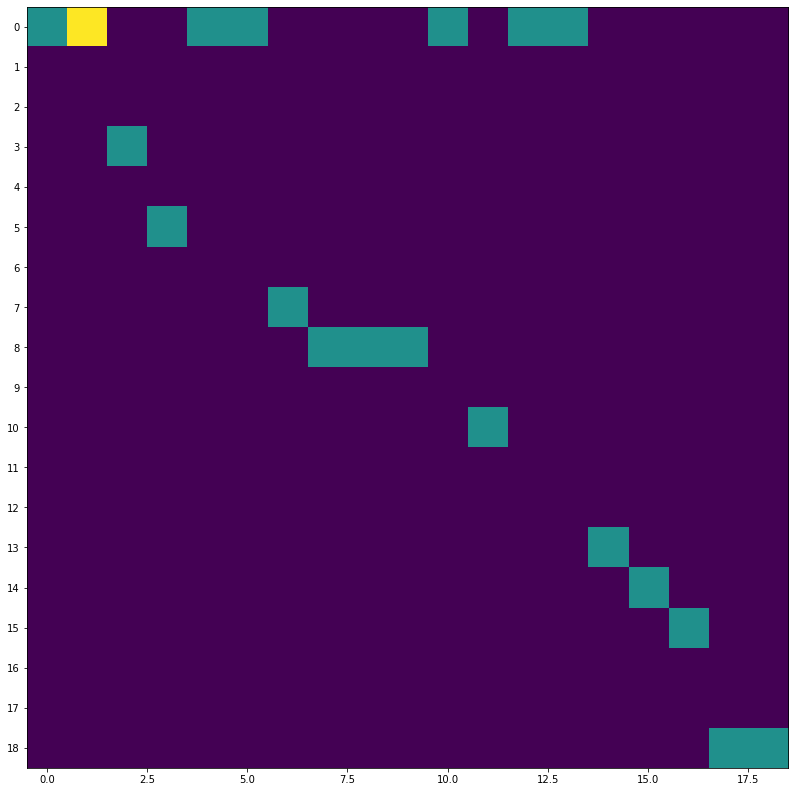

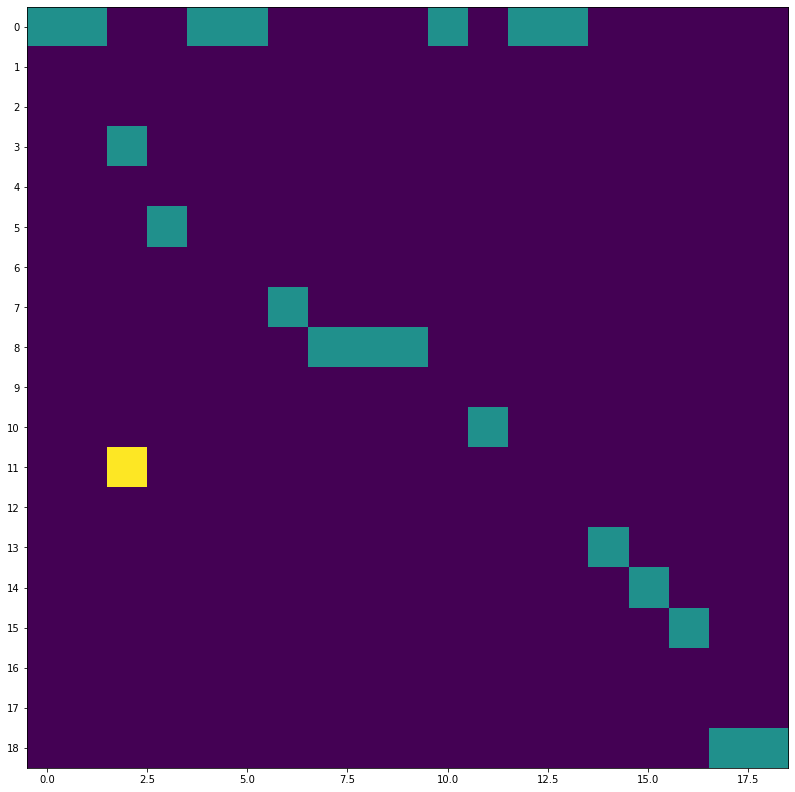

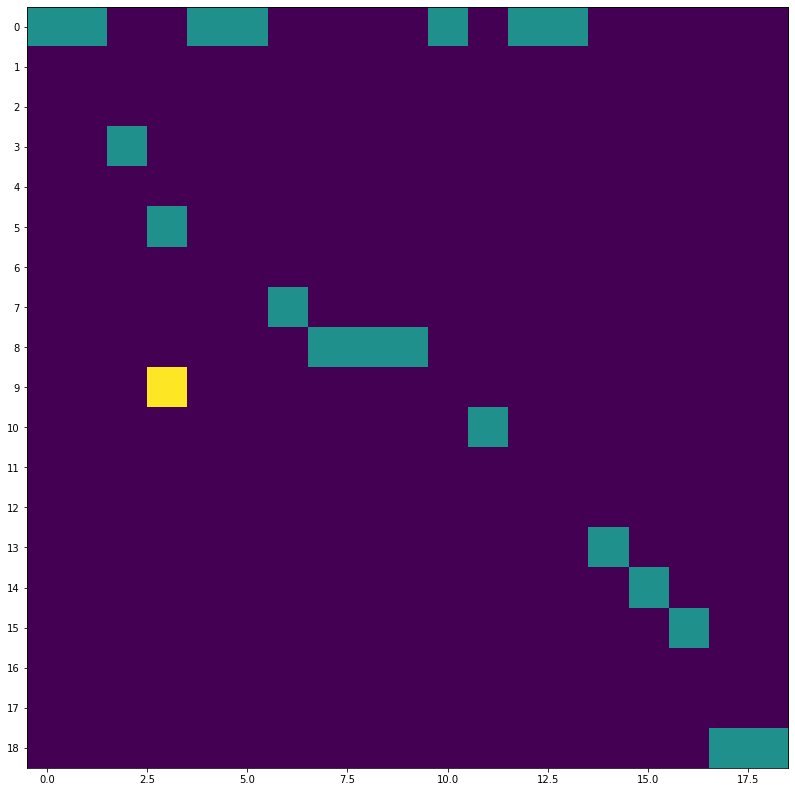

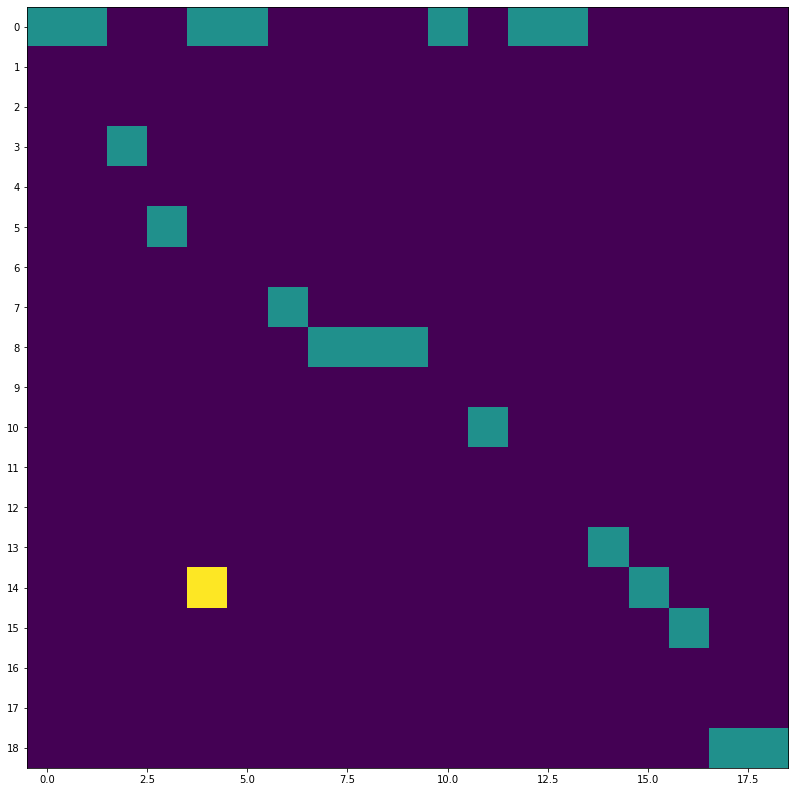

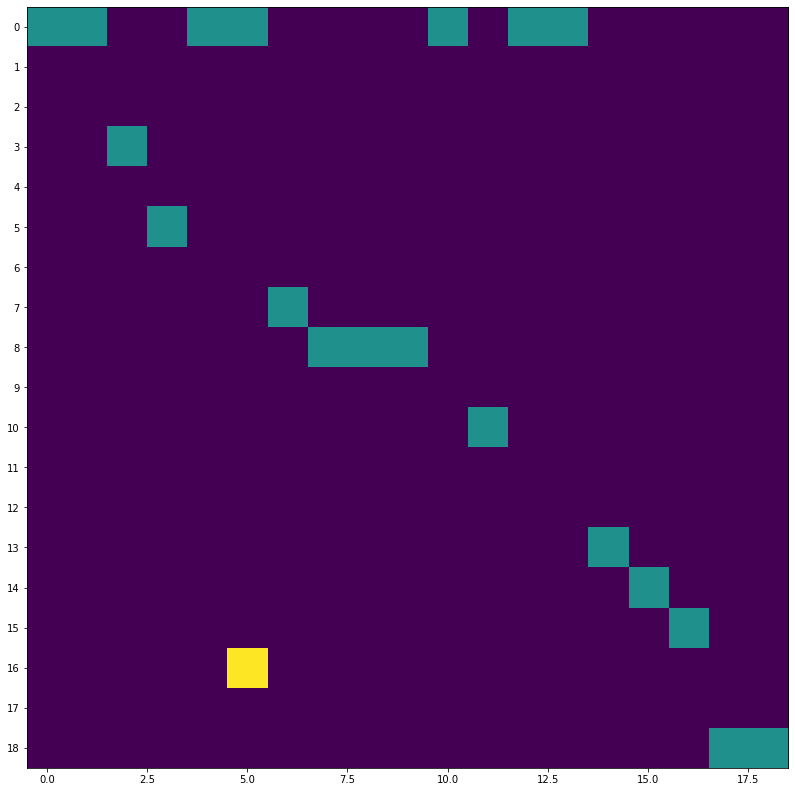

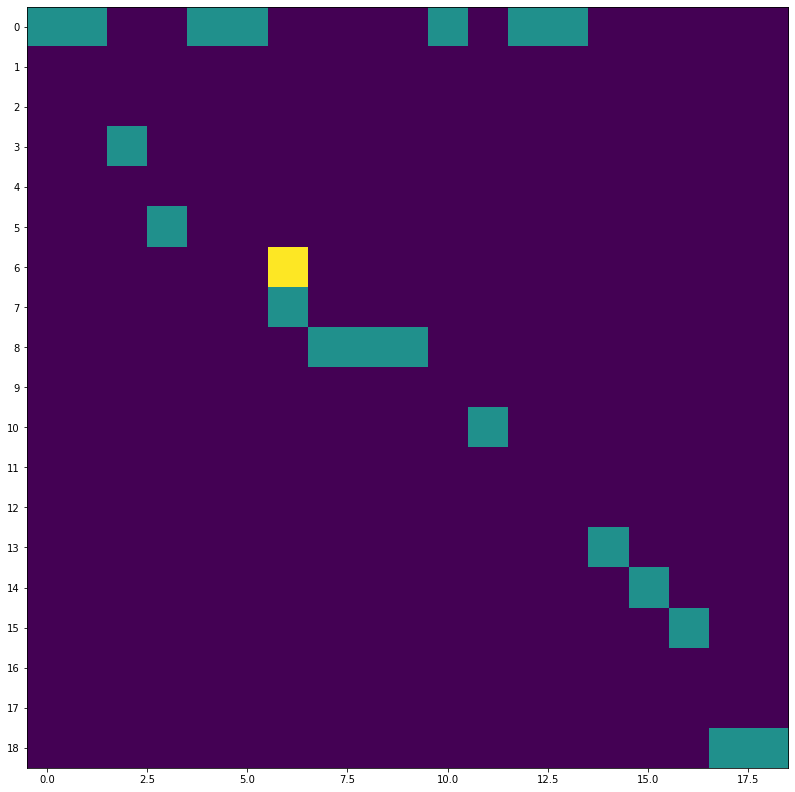

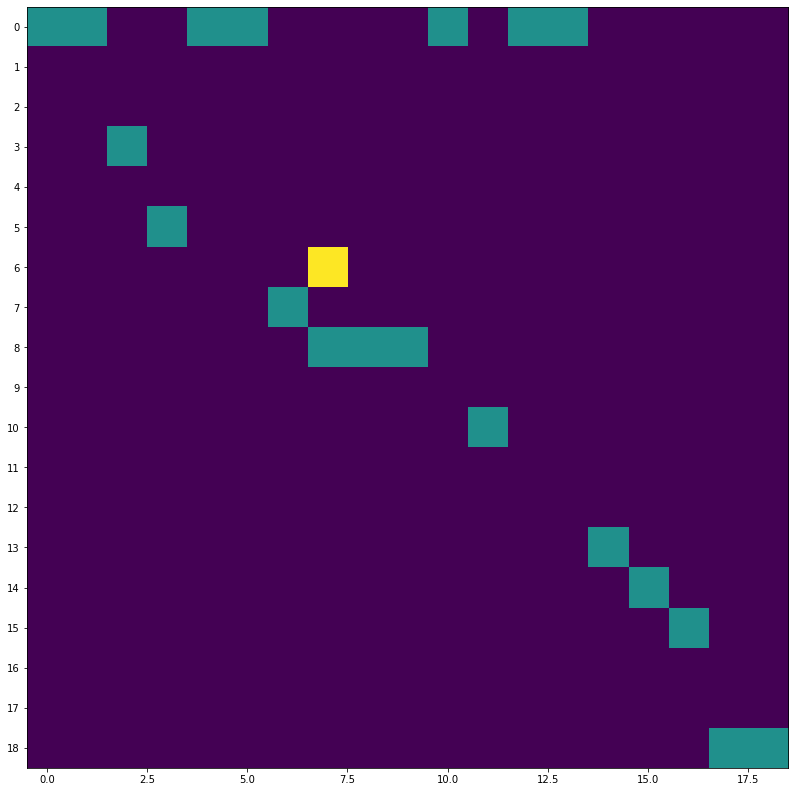

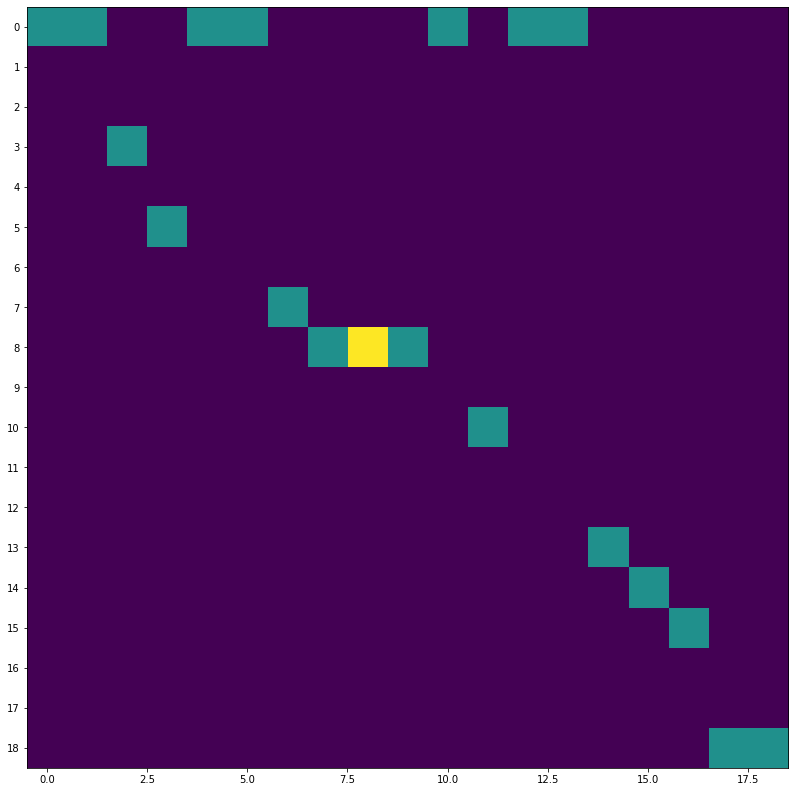

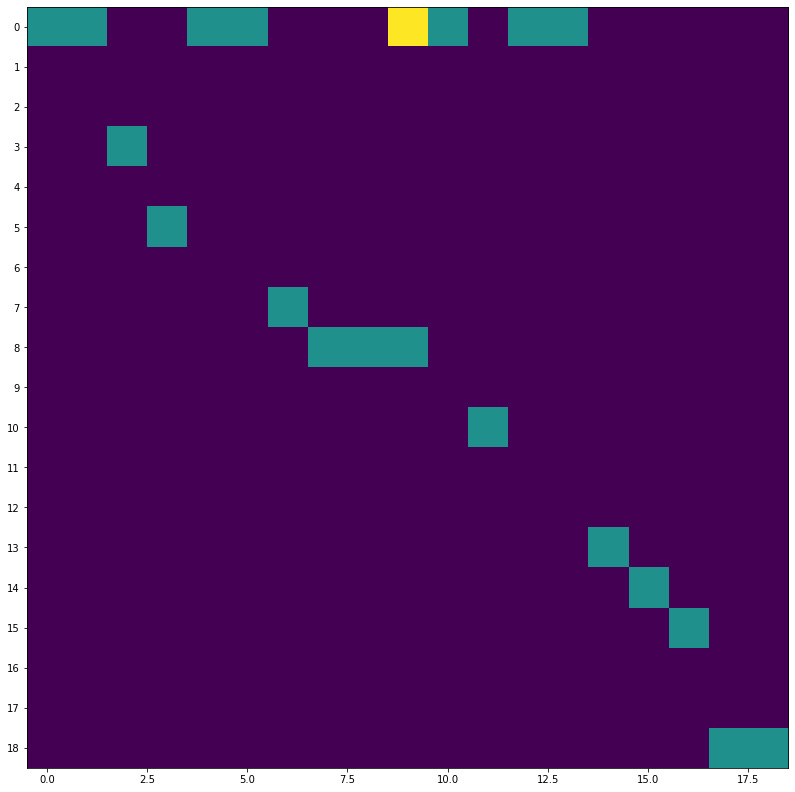

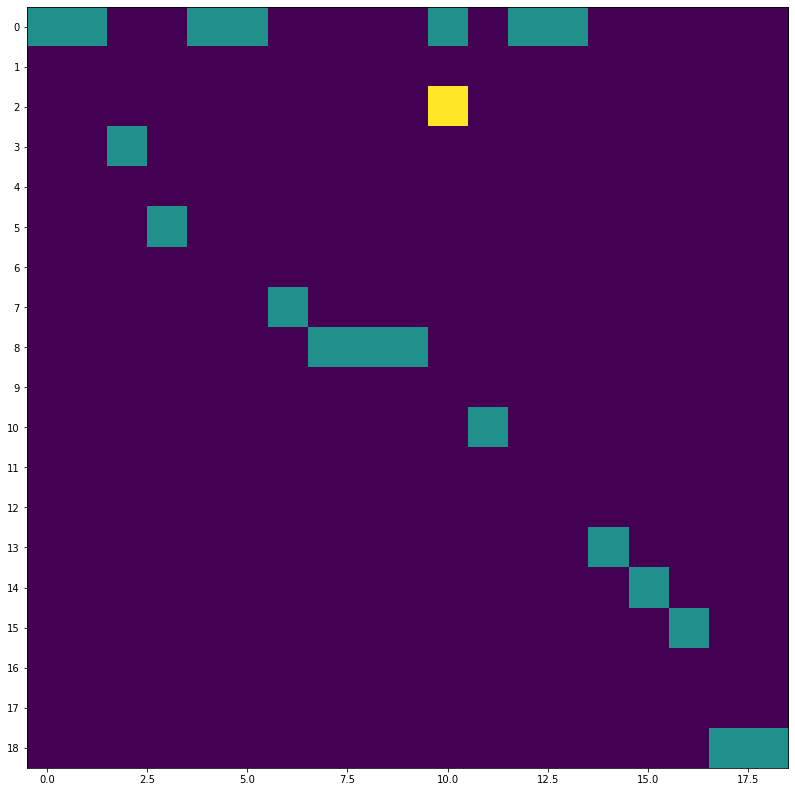

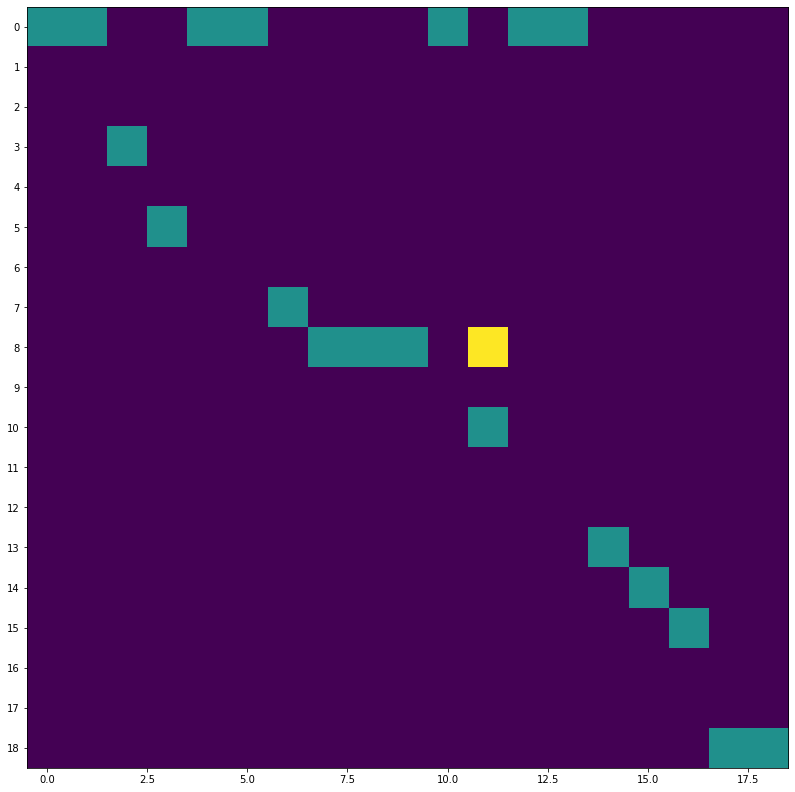

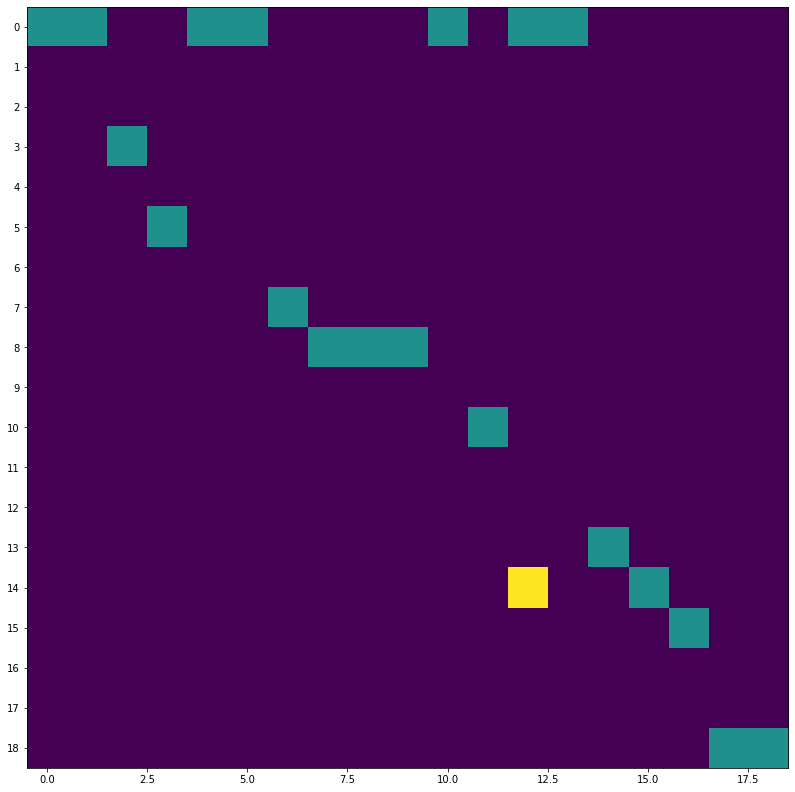

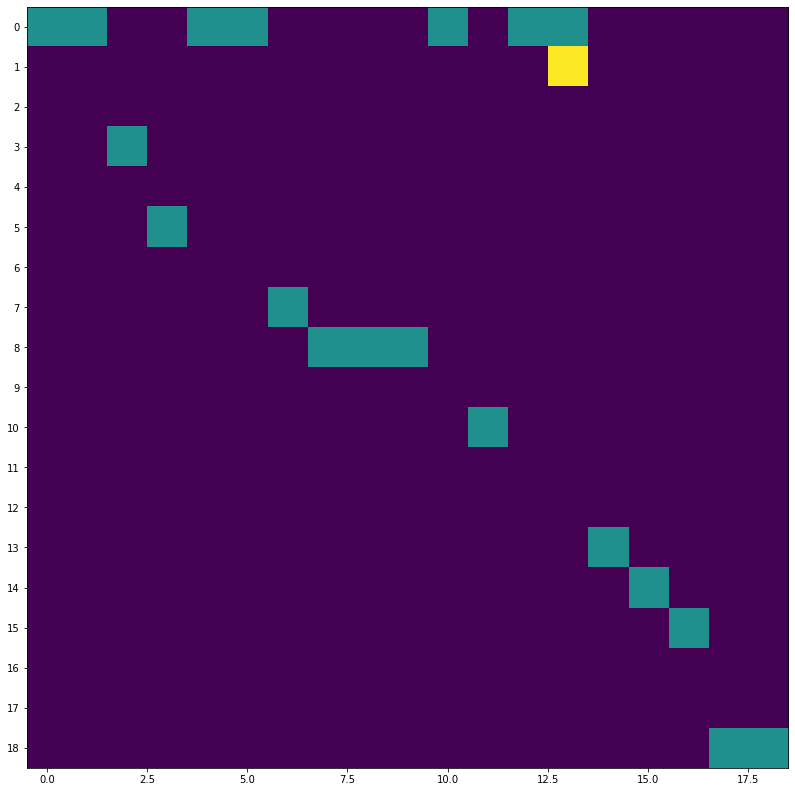

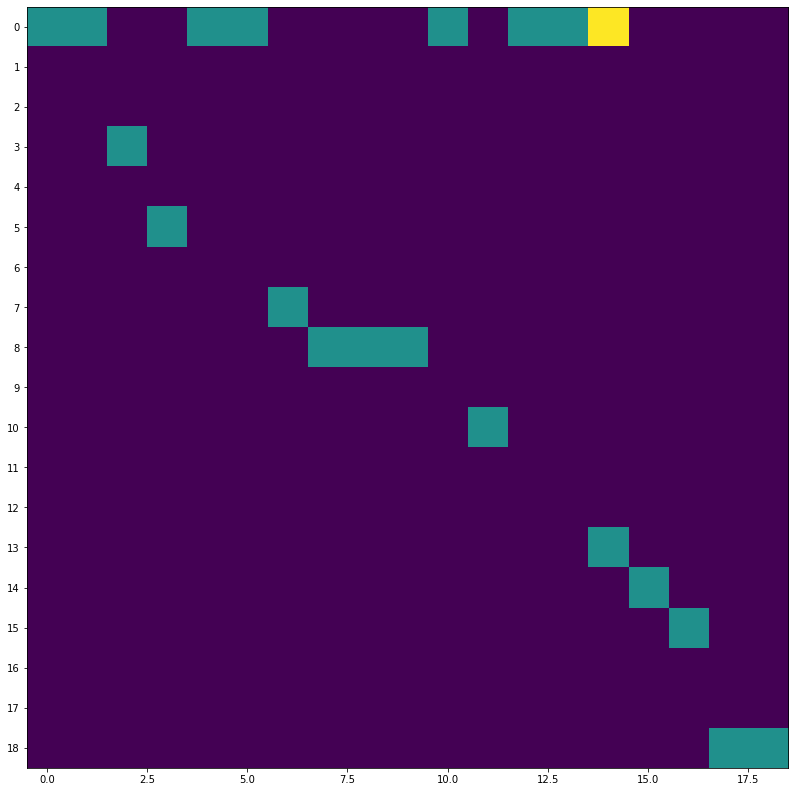

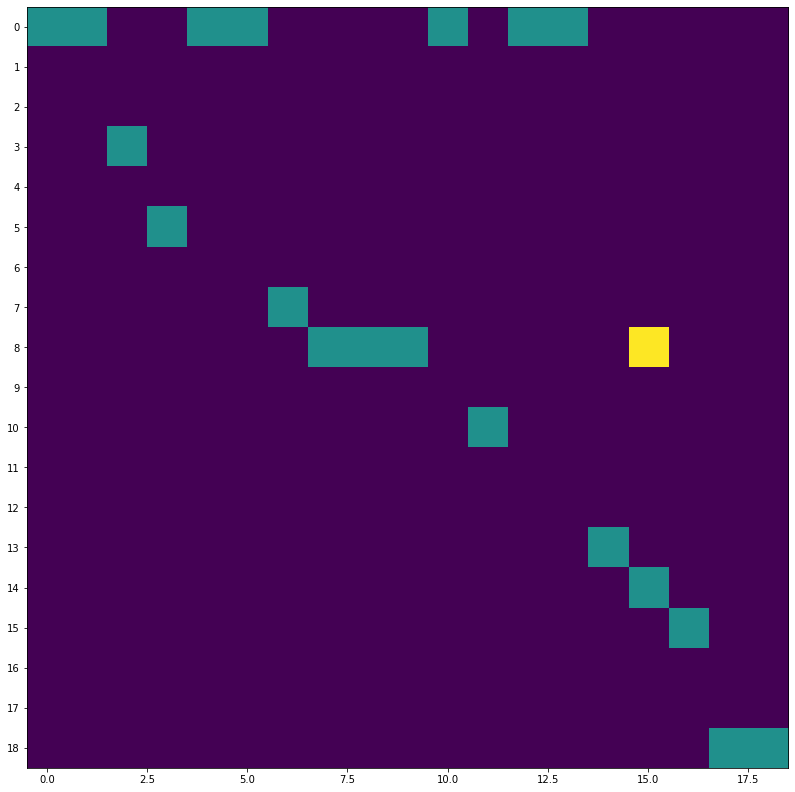

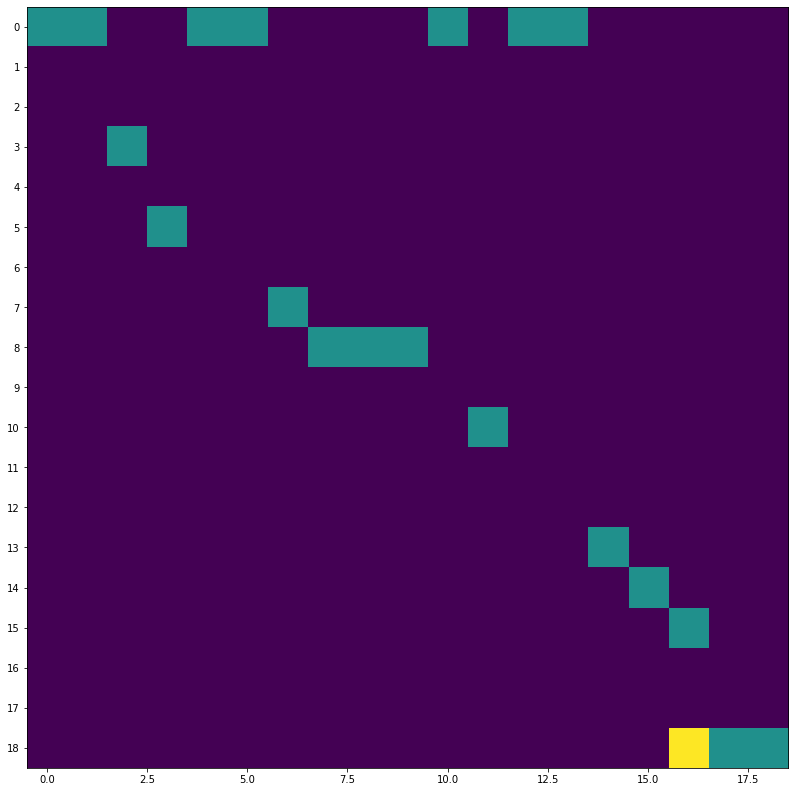

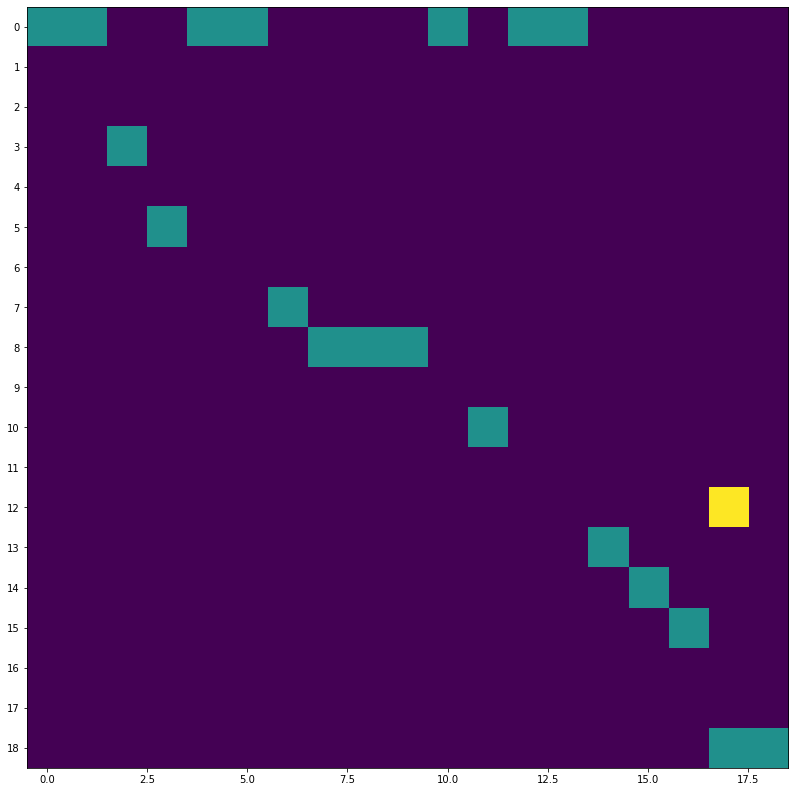

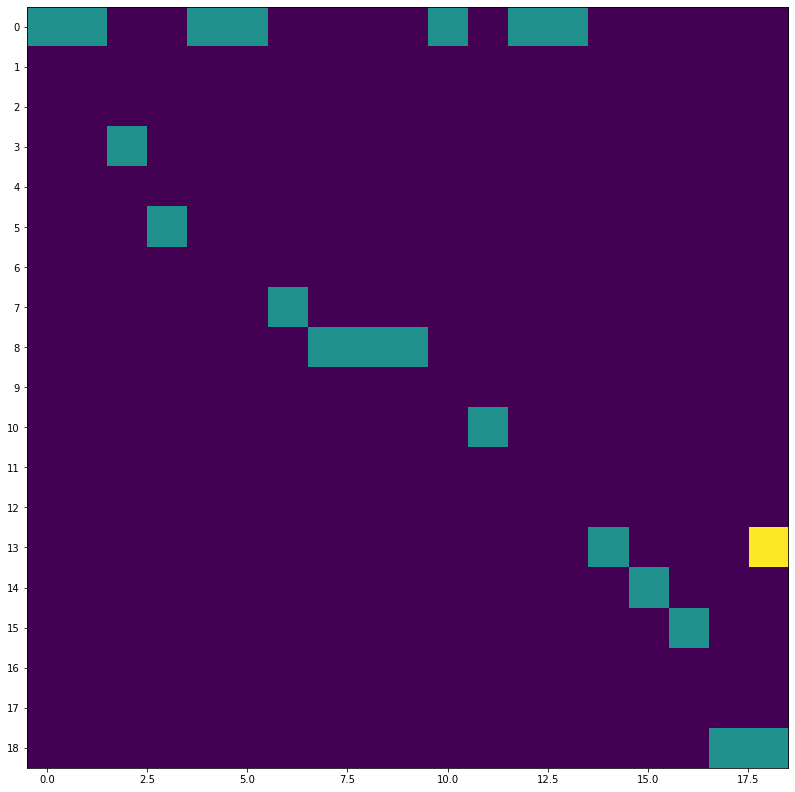

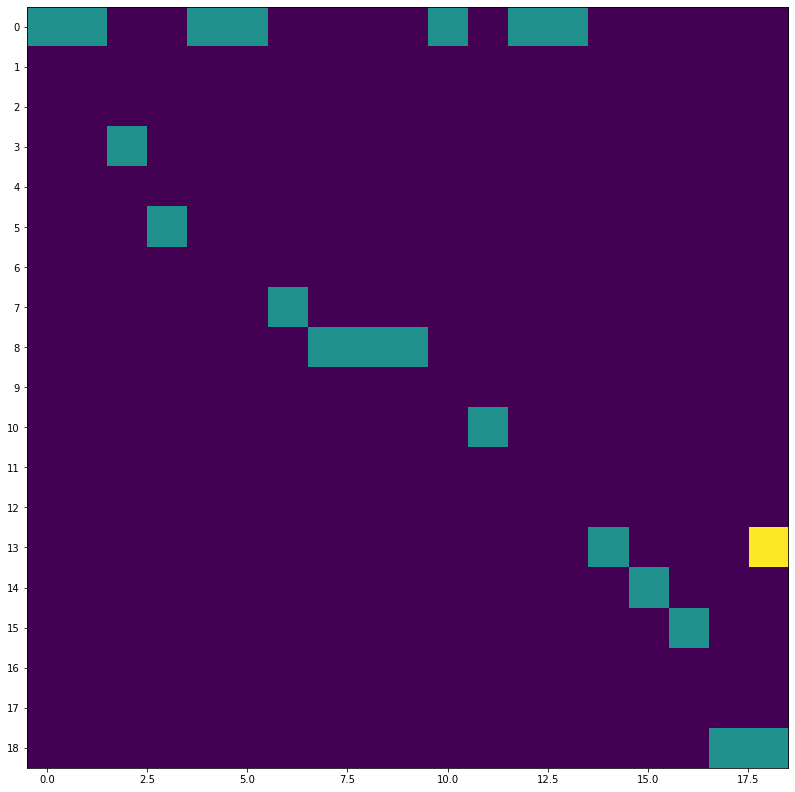

In [337]:
for frame in frames[:]:
    plt.figure(figsize=(22, 14))
    plt.yticks(np.arange(0, 19, 1))
    plt.imshow(frame.T)
    plt.show()

In [344]:
frame

[18, 18]

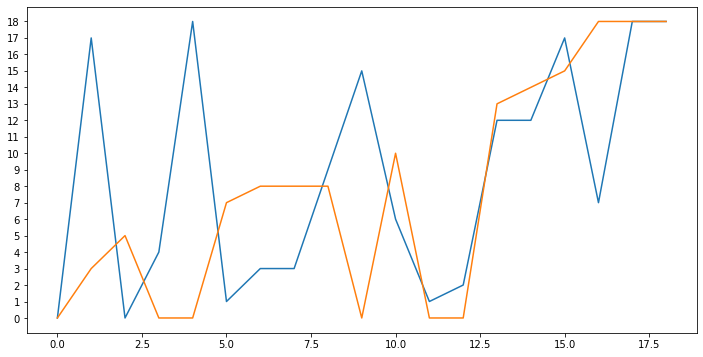

In [343]:
preds = []
targets = []
for frame in frames[:]:
    preds.append(frame[0])
    targets.append(frame[1])
    
    
plt.figure(figsize=(12, 6))
plt.yticks(np.arange(0, 19, 1))
plt.plot(preds)
plt.plot(targets)
plt.show()